# Irreducible Mass of Black Holes

For a BH of mass $M$ spin $\chi\in [0,1]$, the irreducible mass is 
\begin{equation}
M_{\rm irr} = %\sqrt{\frac{M^2+\sqrt{M^4-S^2}}{2}} = 
 M \sqrt{\frac{1+\sqrt{1-\chi^2}}{2}}
\label{mirrdef}
\end{equation}
For convenience, let us define $f= M_{\rm irr}/M$


Suppose you have repeated measurments of $M$ and $\chi$. This is just because we're still frequentists for now. When we will put our Bayesian hat on, these distributions will be the *posterior samples* from a single measurement.

Let's assume that

- the spin $\chi$ is uniformly distributed between 0 and 1.
- the mass $M$ is normally distributed with mean $\mu$ and standard deviation $\sigma$.

These are simplistic assumption that, however, are not too far from what we are now measuring with gravitational-wave detectors. It's a toy model, but not a totally unreasonable one.


In [9]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from numpy import random as rnd

import scipy
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import uniform

from scipy import optimize
from astroML import stats as astroMLstats
from sklearn.neighbors import KernelDensity
from tqdm.notebook import tqdm

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 15

1. Start with a value of $\sigma=0.02$. Note that $\mu$ is a scale and not a parameter: you can normalize all quantities with a dimension of mass by $\mu$. Just set $\mu=1$ in your code and remember that all masses in the problem are measured in units of $\mu$. 

2. Plot the resulting pdf of $M_{\rm irr}$. First try an histogram with one the rules of thumb we've seen above.

3. Using the same samples, plot the distribution of $M_{\rm irr}$ using a KDE.

4. Compute the KS distance between ${M_{\rm irr}}$ and ${f}$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$. 

5. Compute the KS distance between ${M_{\rm irr}}$ and $M$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$.

6. You should find that (i) $M_{\rm irr}$ is distributed like $f$ if ${\sigma}\ll \mu$ and (ii) $M_{\rm irr}$ is distributed like $M$ if  $\sigma\gg \mu$.

7. Compute the pdfs of $M_{\rm irr}$ from their mathematical definitions, plot them, and check they agree with your KDE.

I start by defining the function f:
$f= M_{\rm irr}/M$

In [10]:
def f(spin):
    return ((1+(1-spin**2)**0.5)/(2))**0.5

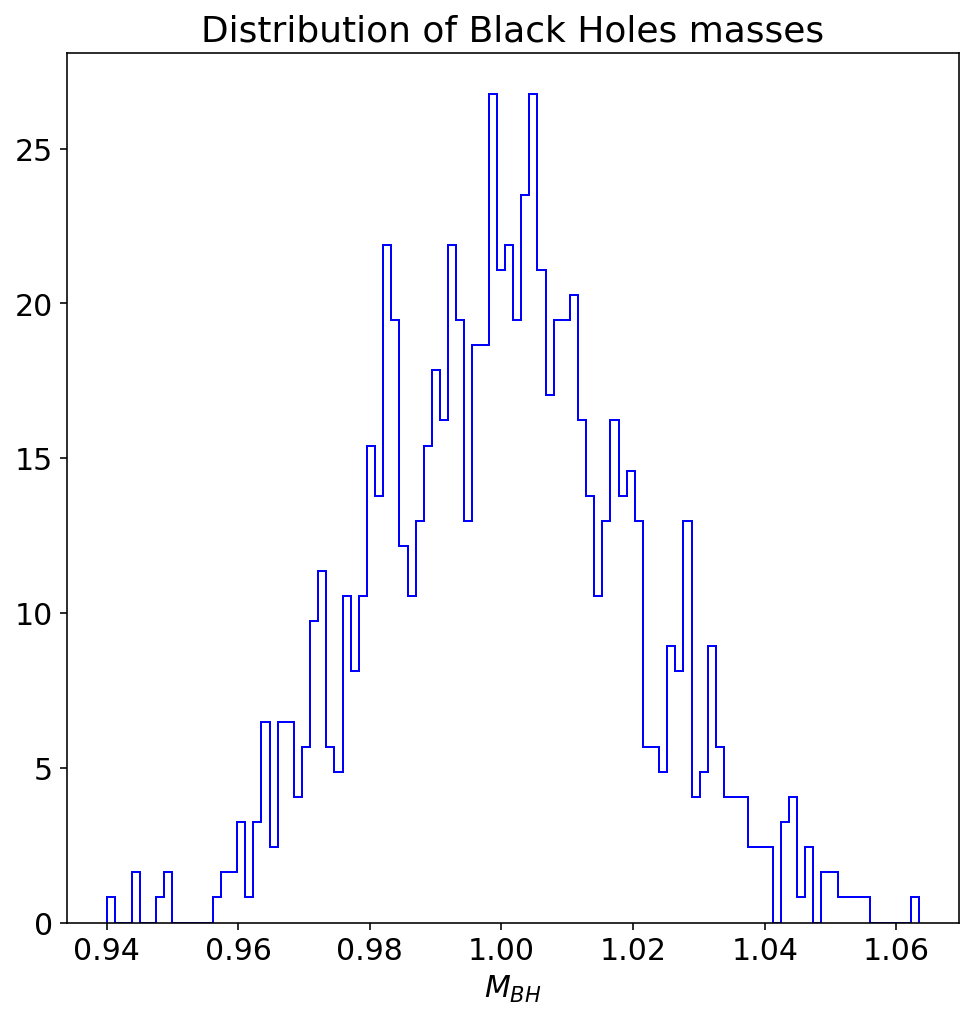

In [11]:
#all the masses are measured in units of mu
sigma = 0.02
mu = 1

N = 1000 #number of samples

np.random.seed(0)
spin = rnd.uniform(0, 1, N) #chi
M = rnd.normal(loc=mu, scale=sigma, size=N) #mass distribution

#plot of the distribution of BH masses
plt.hist(M, bins=100, density=True, histtype='step', color='b')
plt.xlabel('$M_{BH}$')
plt.title('Distribution of Black Holes masses')
plt.show()

Then I plot into an histogram the irreducible masses of the BH, in particular I plot the resulting pdf.

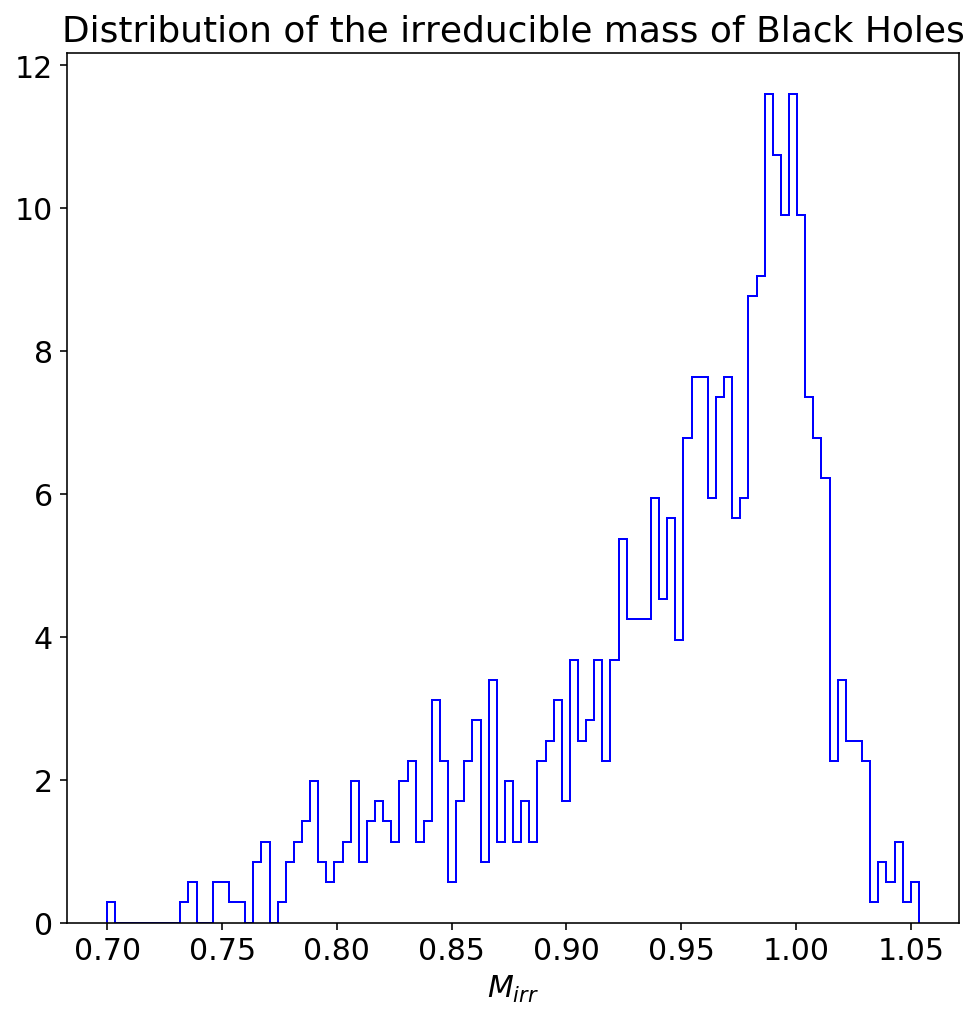

In [12]:
#Now I compute the irreducible mass of BH
#M_irr = np.array([])

F = f(spin) #funtion f=M_Irr/M_BH
M_irr = M*F

plt.hist(M_irr, bins=100, density=True, histtype='step', color='b')
plt.xlabel(r'$M_{irr}$')
plt.title('Distribution of the irreducible mass of Black Holes')
plt.show()

In [13]:
print('The maximum value of the irreducible mass is:', np.max(M_irr))
print('The minimum value of the irreducible mass is:', np.min(M_irr))

The maximum value of the irreducible mass is: 1.053500989149549
The minimum value of the irreducible mass is: 0.69995196138809


# KDE

Using the same samples I plotted the distribution of $M_{irr}$ with a KDE.

In [14]:
#I loaded the KDE module
def kde_sklearn(data, bandwidth = 1.0, kernel="linear"):
    kde_skl = KernelDensity(bandwidth = bandwidth, 
                            kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)

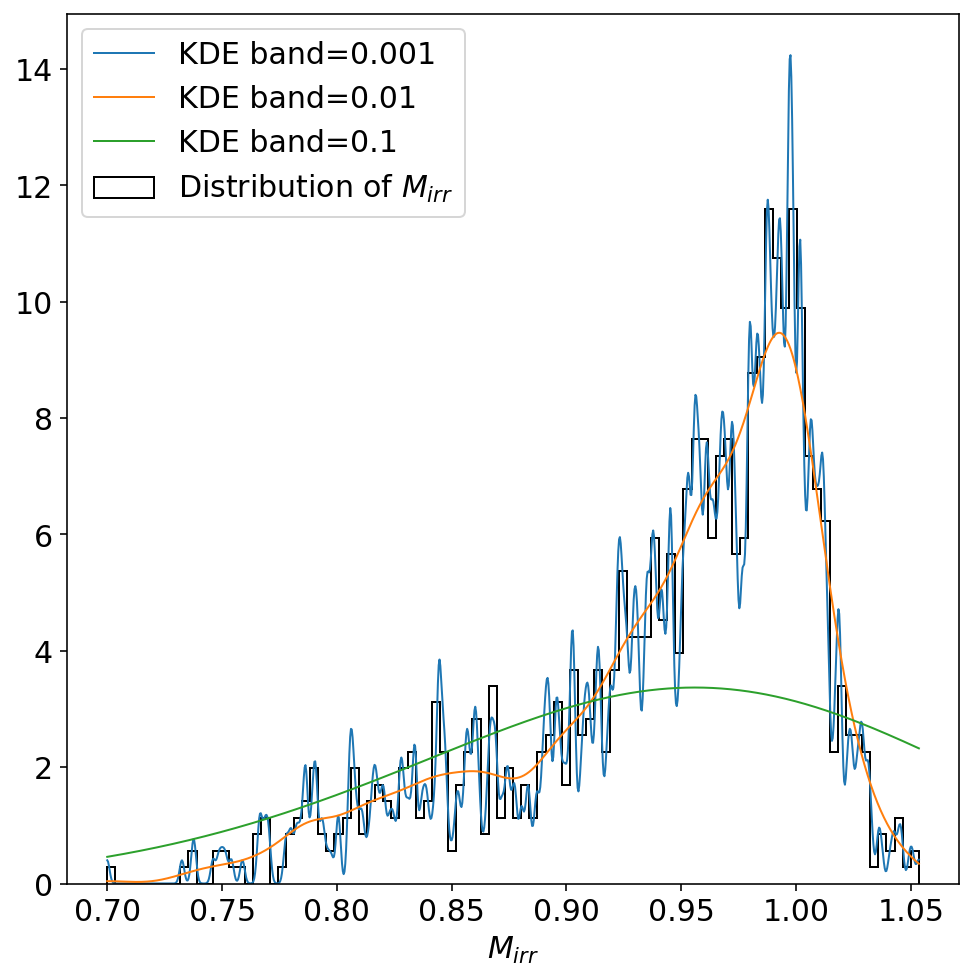

In [15]:
#KDE
x_grid = np.linspace(M_irr.min(), M_irr.max(), 1000)

#different bandwidth
band = [0.001, 0.01, 0.1]
for i in band:
    pdf_M_irr = kde_sklearn(M_irr, i, kernel="gaussian")
    plt.plot(x_grid, pdf_M_irr, label='KDE band='+str(i), lw=1)


plt.hist(M_irr, bins=100, density=True, histtype='step', color='black', label=r'Distribution of $M_{irr}$', lw=1)
plt.legend()
plt.xlabel(r'$M_{irr}$')
plt.show()

From the plot we can see that the best fit is a KDE with bandwidth of the order 0.001.

# KS

Now I compute the KS distance between $M_{irr}$ and f, and then between $M_{irr}$ and M as a function of $\sigma$.

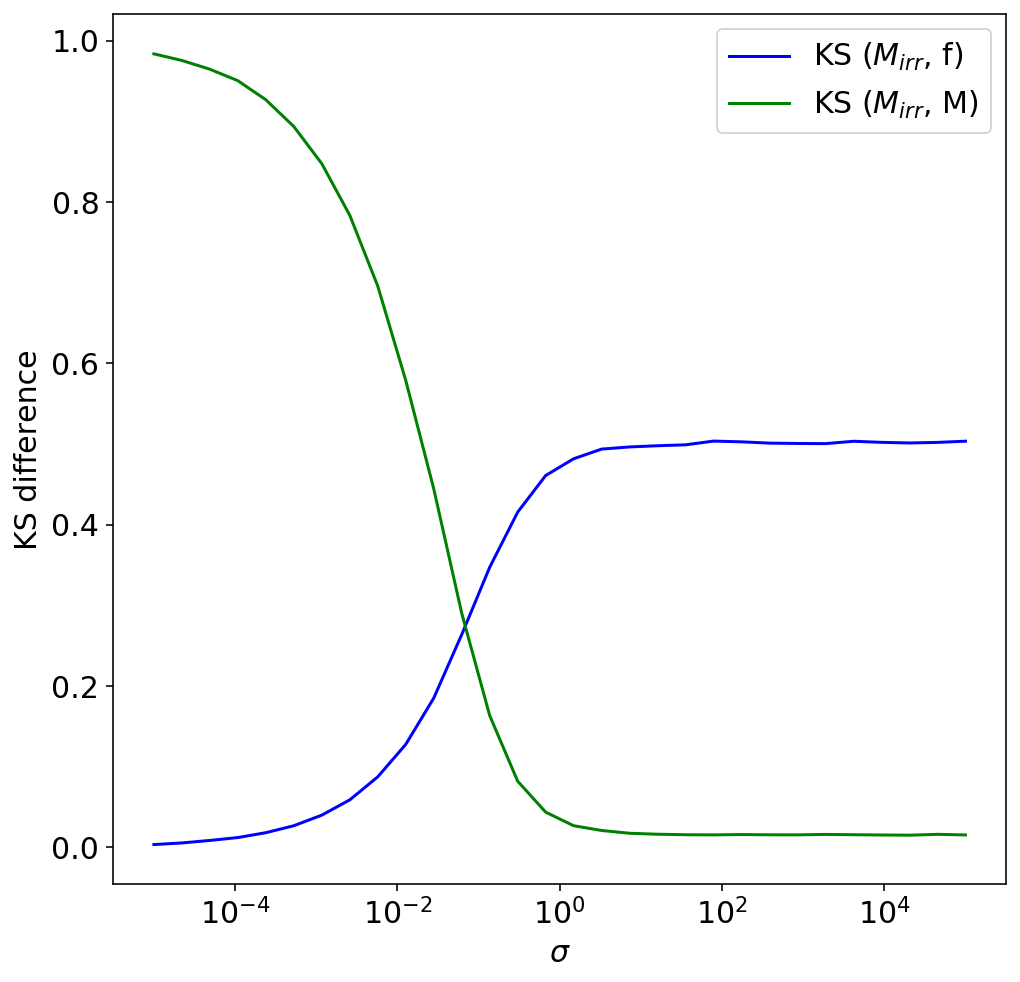

In [16]:
sigma = np.logspace(-5, 5, 30)

ksf = []
ksM = []

N = int(1e5)

for scale in sigma:
    spin = rnd.uniform(0, 1, N)#chi
    F = f(spin)
    M = rnd.normal(loc=mu, scale=scale, size=N)
    
    ksM.append(scipy.stats.ks_2samp(M, M*F))
    ksf.append(scipy.stats.ks_2samp(F, M*F))
    
ksf = np.array(ksf)
ksM = np.array(ksM)

plt.plot(sigma, ksf[:,0], label=r'KS ($M_{irr}$, f)', color='b')
plt.plot(sigma, ksM[:,0], label=r'KS ($M_{irr}$, M)', color='green')
plt.xlabel(r'$\sigma$')
plt.ylabel('KS difference')
plt.semilogx()
plt.legend()
plt.show()
    

For $\sigma$ -> 0 the distribution of $M_{irr}$ goes as the distribution of masses (M), otherwise the distribution of $M_{irr}$ goes as f.

# Exact Solution

Pdf of $M_{irr}$:
\begin{equation}
p(M_{\rm irr})  = \frac{\sqrt{2/\pi}}{\sigma} \int_{1/\sqrt{2}}^1 \exp\left[{-\frac{(M_{\rm irr}/f -\mu)^2}{2\sigma^2}}\right]  \frac{2 f^2-1}{f \sqrt{1 - f^2}}  \,\, {\rm d}f\,. \label{pmirr}
\end{equation}


In [17]:
scale=0.02
x = np.linspace(min(1-5*scale,1/np.sqrt(2)),1+5*scale,N)

def integrand(f,x):
    return ((2/np.pi)**0.5 / scale ) * np.exp(-(x/f -1)**2 /(2*scale**2)) * (2*f**2-1)/(1 - f**2)**0.5 / f


Mirr = [scipy.integrate.quad(lambda f: integrand(f,xt), 1/2**0.5,1)[0] for xt in x]

I plot the irreducible mass distribution and check if it agrees with the KDE at three different bandwidth: 0.001, 0.01, 0.1.

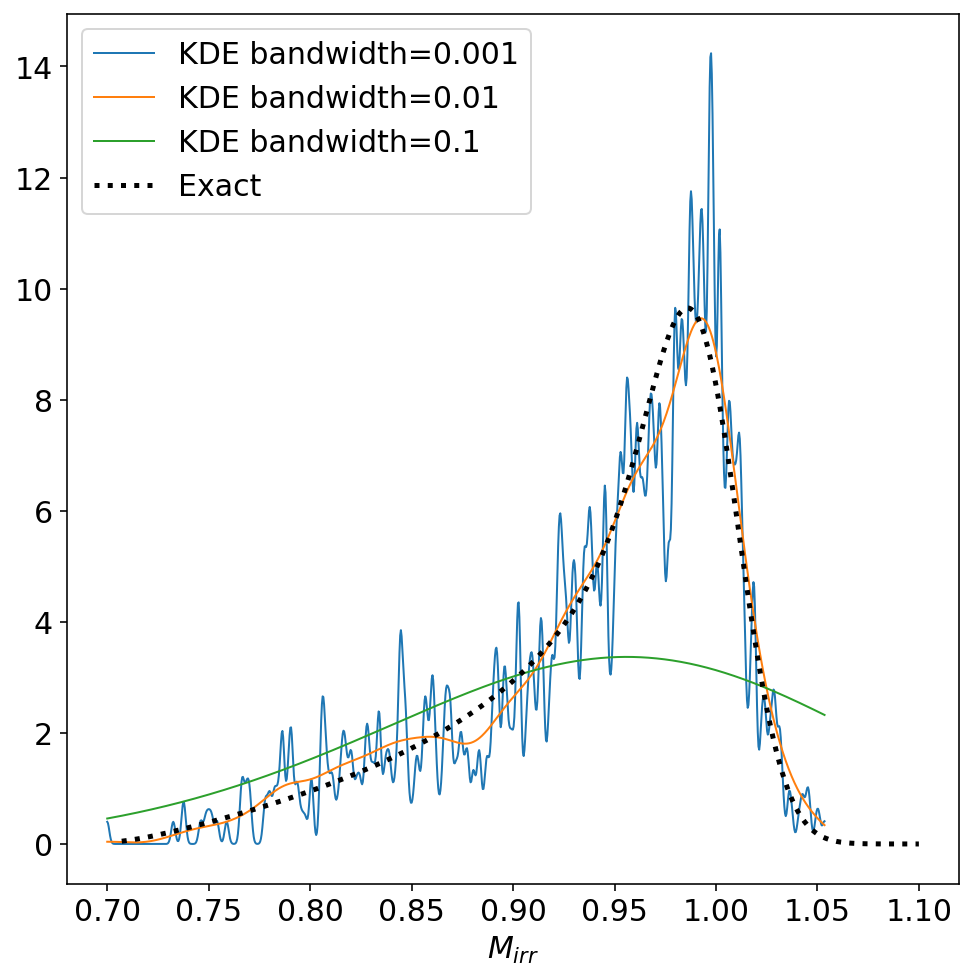

In [18]:
#KDE
band = [0.001, 0.01, 0.1]

for i in band:
    KDE_dist = kde_sklearn(M_irr, i, "gaussian")
    plt.plot(x_grid, KDE_dist, label='KDE bandwidth='+str(i), lw=1)

plt.plot(x,Mirr,label='Exact',c='black',ls='dotted', lw=2.5)
plt.xlabel('$M_{irr}$')
plt.legend()
plt.show()

From the plot the KDE with bandwidth equal to 0.01 seems to better describe the exact solution.